In [33]:
import os
import numpy as np
import pandas as pd
from typing import List
import matplotlib.pyplot as plt

In [104]:
class VolatilityCalculator:
    def __init__(self, rolling_window: int = 5):
        self.rolling_window = rolling_window

    def garman_klass_parkinson_vols(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Calculates Garman-Klass and Parkinson volatilities for a given DataFrame.

        Parameters:
        df: pd.DataFrame
            Input DataFrame containing the necessary columns: 'MicroPrice_open', 'MicroPrice_high',
            'MicroPrice_low', 'MicroPrice_close'.

        Returns:
        pd.DataFrame
            DataFrame with additional columns 'garman_klass_vol', 'parkinson_vol', and 'bipower_var'.
        """

        df['log_hl'] = (df['MicroPrice_high'] / df['MicroPrice_low']).replace([np.inf, -np.inf], np.nan).apply(
            np.log).fillna(0)
        df['log_cc'] = (df['MicroPrice_close'] / df['MicroPrice_open']).replace([np.inf, -np.inf], np.nan).apply(
            np.log).fillna(0)
        df['garman_klass_vol'] = np.sqrt(0.5 * df['log_hl'] ** 2 - (2 * np.log(2) - 1) * df['log_cc'] ** 2)
        df['log_hl_squared'] = np.log(df['MicroPrice_high'] / df['MicroPrice_low']) ** 2
        df['parkinson_vol'] = np.sqrt((1 / (4 * np.log(2))) * df['log_hl_squared'].mean())
        df['bipower_var'] = (np.abs(df['log_hl']) * np.abs(df['log_hl'].shift(1))).rolling(self.rolling_window).sum()

        return df

    def calculate_midquote_returns(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Calculates Midquote Squared Return (MQSR) and Midquote Absolute Return (MQAR) for a given DataFrame.

        Parameters:
        df: pd.DataFrame
            Input DataFrame containing the necessary columns: 'MicroPrice_open', 'MicroPrice_high',
            'MicroPrice_low', 'MicroPrice_close'.

        Returns:
        pd.DataFrame
            DataFrame with additional columns 'MQSR' (Midquote Squared Return) and 'MQAR' (Midquote Absolute Return).
        """

        midquote = (df['MicroPrice_high'] + df['MicroPrice_low']) / 2

        mqsr = np.square(np.log(midquote) - np.log(midquote.shift(1)))
        mqar = np.abs(np.log(midquote) - np.log(midquote.shift(1)))
        mret = np.log(midquote) - np.log(midquote.shift(1))

        df['MQSR'] = mqsr
        df['MQAR'] = mqar
        df['mret'] = mret

        return df

    def compute_spreads(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Computes Effective Spread and Realized Spread for a given DataFrame.

        Parameters:
        df: pd.DataFrame
            Input DataFrame containing the necessary columns.

        Returns:
        pd.DataFrame
            DataFrame with additional columns 'EffectiveSpread' and 'RealizedSpread'.

        Notes:
        - The function assumes that the DataFrame has columns 'BASpread_median', 'time_open', 'time_close',
          'TradePrice_median', and the necessary columns for calculating dt.
        - The function also replaces extreme spread values with the median of non-extreme values.
        """

        df['bid_offer'] = df['BestAsk_median']- df['BestBid_median']
        bid_offer_shifted = (df['bid_offer'].shift(-100) + df['bid_offer'].shift(-100)) / 2
        dt = pd.to_timedelta(df['time_close'] - df['time_open']).dt.total_seconds() / 3600

        effective_spread = 2 * dt * (df['TradePrice_median'] - df['bid_offer'])
        realized_spread = 2 * dt * (df['TradePrice_median'] - bid_offer_shifted)

        spreads_df = pd.DataFrame({
            'EffectiveSpread': effective_spread,
            'RealizedSpread': realized_spread
        })
        # Compute the median of the non-extreme values
        lower_percentile = np.percentile(spreads_df, 10)
        upper_percentile = np.percentile(spreads_df, 90)
        non_extreme_spreads = spreads_df[(spreads_df >= lower_percentile) & (spreads_df <= upper_percentile)]
        median_spread = np.median(non_extreme_spreads)

        # Replace extreme values with the median
        spreads_df[spreads_df < lower_percentile] = median_spread
        spreads_df[spreads_df > upper_percentile] = median_spread
        df['EffectiveSpread'] = spreads_df['EffectiveSpread']
        df['RealizedSpread'] = spreads_df['RealizedSpread']

        return df



def resample_event_clock_two(df, event_clock_column: str, event_clock_threshold: int,
                             exclude_median_columns: List[str], columns_to_resample: List[str]) -> pd.DataFrame:
    """
    Resamples a dataframe using an event-based clock.

    Parameters:
    df: pd.DataFrame
        The input dataframe to be resampled.
    event_clock_column: str
        The column name in df to be used as event clock.
    event_clock_threshold: int
        The threshold of cumulative number of events to define clock ticks.
    exclude_median_columns: list
        List of column names for which median should not be computed.
    columns_to_resample: list
        Columns for which first, max, min, last, and median need to be computed.

    Returns:
    resampled_df: pd.DataFrame
        The resampled dataframe.
    """

    # Ensure no NaN values in the event clock column
    df[event_clock_column].fillna(0, inplace=True)

    # Create event clock
    df['clockEvents'] = (df[event_clock_column].cumsum() // event_clock_threshold).astype(int)

    # Create OHLC dictionary
    ohlc_dict = {arg: ['first', 'max', 'min', 'last'] for arg in columns_to_resample}

    # Add Open operation using lambda function
    ohlc_dict.update({col: ['first', 'max', 'min', 'last'] + [lambda x: x.iloc[0]] for col in columns_to_resample})

    # Create median dictionary only for numeric columns
    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()

    # Remove excluded columns from the list for median calculation
    median_cols = [col for col in numeric_cols if col not in exclude_median_columns]
    median_dict = {col: 'median' for col in median_cols}

    # Add event clock column to dictionary
    event_clock_dict = {event_clock_column: 'sum'}

    # Merge dictionaries
    agg_dict = {**ohlc_dict, **median_dict, **event_clock_dict}

    # Resample the dataframe
    resampled_df = df.groupby('clockEvents').agg(agg_dict)

    # Compute Open, High, Low, Close values for each column in args
    for arg in columns_to_resample:
        resampled_df[arg + '_open'] = df.groupby('clockEvents')[arg].first()
        resampled_df[arg + '_high'] = df.groupby('clockEvents')[arg].max()
        resampled_df[arg + '_low'] = df.groupby('clockEvents')[arg].min()
        resampled_df[arg + '_close'] = df.groupby('clockEvents')[arg].last()
    # Add Garman-Klass volatility calculation
    resampled_df.columns = ['_'.join(map(str, col)).rstrip("_") for col in resampled_df.columns]
        # Reset the index
    resampled_df.reset_index(drop=True, inplace=True)
    return resampled_df


In [105]:
def read_pkl_idx(file_loc, file_idx):
    """
    Reads a pickle file based on the given file location and index.
    This function reads a pickle file based on the given file location and index.
    It can be used to read a specific pickle file containing financial data for further analysis.

    :param file_loc: str, file location containing the pickle files
    :param file_idx: int, index of the file to read
    :return: dict, content of the pickle file
    """
    files = os.listdir(file_loc)
    file_idx_loc = os.path.join(file_loc, files[file_idx])
    dict_idx = pd.read_pickle(file_idx_loc)
    return dict_idx


In [4]:
recostructedLOBFolder = '/media/ak/Data/InterestRateFuturesData/ReconstructedLOB/'
irfFolder = '/media/ak/Data/InterestRateFuturesData/'
eventClockFiles = os.path.join(irfFolder, 'EventClocksFiles')
symbols = [f for f in os.listdir(eventClockFiles) if str('.json') not in f]
symbolIDX =10
symbolPath = os.path.join(eventClockFiles, symbols[symbolIDX])
# bar =['tick', 'dollar', 'volume']
# ticksymbolPath = os.path.join(symbolPath, bar[0])
# dollarsymbolPath = os.path.join(symbolPath, bar[1])
# volumesymbolPath = os.path.join(symbolPath, bar[2])


In [5]:
lobSymbol = os.path.join(recostructedLOBFolder, symbols[symbolIDX])

# read the reconstructed LOB

In [89]:
dfTest =read_pkl_idx(lobSymbol, 10)
dfTest =dfTest.fillna(method='ffill')

In [90]:
event_clock_column = str('NoOfTrades')
event_clock_threshold= 1
columns_to_resample = ['time','BestBid',
   'BestAsk',
   'MicroPrice',
   'arrival_rate',
   'MeanRelativeTickVolume',
   'OrderImbalance']
exclude_median_columns = ['']

# resample the DataFrame

In [91]:
resampledDf0rig = resample_event_clock_two(dfTest, event_clock_column, event_clock_threshold,
                             exclude_median_columns, columns_to_resample)

In [92]:
# Reset the index
resampledDf = resampledDf0rig.copy(deep=True)
resampledDf.reset_index(drop=True, inplace=True)

In [94]:
resampledDf = resampledDf.fillna(method ='ffill')

In [100]:

calculator = VolatilityCalculator(rolling_window=3)

# # Apply volatility calculations on the DataFrame
resampled_df = calculator.garman_klass_parkinson_vols(resampledDf)
resampled_df = calculator.calculate_midquote_returns(resampledDf)
resampled_df = calculator.compute_spreads(resampled_df)
resampled_df_final = resampled_df.fillna(method ='ffill')
resampled_df_final['pct_changes'] = (resampled_df_final.MicroPrice_median.pct_change().replace([np.inf, -np.inf], np.nan).apply(np.log).fillna(method = 'ffill')).replace([np.inf, -np.inf], 0)
resampled_df['simple_vol'] = np.sqrt(resampled_df_final.pct_changes.rolling(2).std())


In [107]:
df_test =pd.read_pickle('/media/ak/Data/InterestRateFuturesData/EventClocksFiles/US1/tick/20180611.pkl')

In [108]:
df_test.columns.values

array(['time_first', 'time_max', 'time_min', 'time_last',
       'time_<lambda_0>', 'BestBid_median', 'BestAsk_median',
       'MicroPrice_median', 'arrival_rate_median',
       'MeanRelativeTickVolume_median', 'OrderImbalance_median',
       'TradePrice_median', 'TradedVolume_median', 'NoOfTrades_sum',
       'AverageVolumePerTrade_median', 'CCYTradedVolume_median',
       'value_median', 'size_median', 'BidSize_median', 'AskSize_median',
       'CumlTradingVolume_median', 'CCYCumlVolume_median',
       'CumlNoOfTrades_median', 'CumlTradedVolume_median',
       'RunningNoOfTrades_median', 'RunningCumlVolume_median',
       'RunningCumlNoOfTrades_median', 'BASpread_median',
       'QuoteSize_median', 'MidPrice_median',
       'ExpandingMeanRelativeTickVolume_median', 'clockEvents_median',
       'time_open', 'time_high', 'time_low', 'time_close', 'BestBid_open',
       'BestBid_high', 'BestBid_low', 'BestBid_close', 'BestAsk_open',
       'BestAsk_high', 'BestAsk_low', 'BestAsk_close',

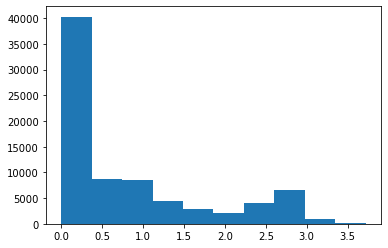

In [116]:
_=plt.hist(df_test.simple_vol)

In [117]:
dfFB1d0llar = pd.read_pickle('/media/ak/Data/InterestRateFuturesData/EventClocksFiles/FB1/dollar/20180620.pkl')

In [120]:
dfFB1d0llar.columns.values

array(['time_first', 'time_max', 'time_min', 'time_last',
       'time_<lambda_0>', 'BestBid_median', 'BestAsk_median',
       'MicroPrice_median', 'arrival_rate_median',
       'MeanRelativeTickVolume_median', 'OrderImbalance_median',
       'TradePrice_median', 'TradedVolume_median', 'NoOfTrades_median',
       'AverageVolumePerTrade_median', 'CCYTradedVolume_sum',
       'value_median', 'size_median', 'BidSize_median', 'AskSize_median',
       'CumlTradingVolume_median', 'CCYCumlVolume_median',
       'CumlNoOfTrades_median', 'CumlTradedVolume_median',
       'RunningNoOfTrades_median', 'RunningCumlVolume_median',
       'RunningCumlNoOfTrades_median', 'BASpread_median',
       'QuoteSize_median', 'MidPrice_median',
       'ExpandingMeanRelativeTickVolume_median', 'clockEvents_median',
       'time_open', 'time_high', 'time_low', 'time_close', 'BestBid_open',
       'BestBid_high', 'BestBid_low', 'BestBid_close', 'BestAsk_open',
       'BestAsk_high', 'BestAsk_low', 'BestAsk_close',

In [124]:
dfFB1d0llar['MicroPrice_high'].rolling(3).mean()

0             NaN
1             NaN
2      158.782063
3      158.773175
4      158.773556
          ...    
128    158.688547
129    158.670769
130    158.660000
131    158.660000
132    158.660000
Name: MicroPrice_high, Length: 133, dtype: float64

In [147]:
test1 = pd.read_pickle('/media/ak/Data/InterestRateFuturesData/EventClocksFiles/XM1/dollar/20181014.pkl')
test2 = pd.read_pickle('/media/ak/Data/InterestRateFuturesData/EventClocksFiles/YM1/tick/20180716.pkl')
test3 = pd.read_pickle('/media/ak/Data/InterestRateFuturesData/EventClocksFiles/YM1/tick/20180816.pkl')

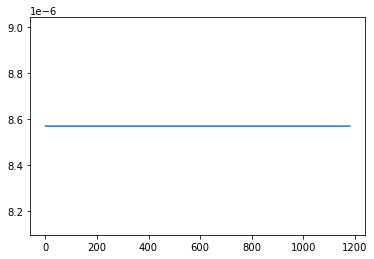

In [148]:
test1.parkinson_vol.plot()

In [157]:
test3.CCYCumlVolume_median.median()

7435085.825

In [160]:
test3.TradedVolume_median.median()

9.0

In [161]:
test4 = pd.read_pickle('/media/ak/Data/InterestRateFuturesData/EventClocksFiles/US1/dollar/20180425.pkl')
test5 = pd.read_pickle('/media/ak/Data/InterestRateFuturesData/EventClocksFiles/US1/tick/20180531.pkl')
test6 = pd.read_pickle('/media/ak/Data/InterestRateFuturesData/EventClocksFiles/US1/tick/20180809.pkl')

In [165]:
test4.describe().T

,count,mean,std,min,25%,50%,75%,max
BestBid_median,23842.0,141.941829,0.199916,141.531250,141.781250,141.937500,142.031250,142.500000
BestAsk_median,23842.0,141.973098,0.200046,141.562500,141.828125,141.968750,142.062500,142.531250
MicroPrice_median,23842.0,141.957564,0.199964,141.532915,141.812500,141.949765,142.055149,142.520699
arrival_rate_median,23842.0,0.000105,0.000119,0.000012,0.000023,0.000064,0.000151,0.001401
MeanRelativeTickVolume_median,23842.0,2.817163,13.785646,0.000000,0.000000,0.000000,0.000000,360.071407
...,...,...,...,...,...,...,...,...
bid_offer,23841.0,0.031270,0.008220,-0.015625,0.031250,0.031250,0.031250,0.078125
EffectiveSpread,23841.0,0.227222,2.152704,0.000000,0.000000,0.000000,0.078889,283.468750
RealizedSpread,23841.0,0.225672,2.149538,0.000000,0.000000,0.000000,0.078889,283.437500
pct_changes,23841.0,-9.926491,2.747525,-21.186285,-11.037546,-10.137393,-9.378353,0.000000


In [166]:
test6.describe().T

,count,mean,std,min,25%,50%,75%,max
BestBid_median,35724.0,143.025143,0.262703,142.562500,142.781250,143.093750,143.218750,143.500000
BestAsk_median,35724.0,143.056408,0.262658,142.593750,142.812500,143.125000,143.250000,143.531250
MicroPrice_median,35724.0,143.040621,0.262538,142.568685,142.787106,143.093750,143.249723,143.528895
arrival_rate_median,35724.0,0.000087,0.000156,0.000012,0.000012,0.000023,0.000093,0.001953
MeanRelativeTickVolume_median,35724.0,1.619721,12.164175,0.000000,0.000000,0.000000,0.000000,538.976134
...,...,...,...,...,...,...,...,...
bid_offer,35723.0,0.031265,0.006707,-0.031250,0.031250,0.031250,0.031250,0.078125
EffectiveSpread,35723.0,0.098086,0.873846,0.000000,0.000000,0.000000,0.079583,155.846510
RealizedSpread,35723.0,0.097040,0.872433,0.000000,0.000000,0.000000,0.079583,155.846510
pct_changes,35722.0,-9.652769,3.342880,-19.828652,-10.879622,-10.016491,-9.317777,0.000000
